# W2D1 Tutorial 7: Scenario-dependence of future changes in extremes

#### __Week 2, Day 4, Extremes & Vulnerability__
##### __Content creators:__ Matthias Aengenheyster, Joeri Reinders
##### __Content reviewers:__ TBD
##### __Content editors:__ TBD
##### __Production editors:__ TBD
##### __Our 2023 Sponsors:__ TBD

## Tutorial Objectives:

For this 7th tutorial we will study climate model output for different cities in the world, and look at how extreme temperature and precipitation changes over time and depending on emission scenarios.

Here we use data from climate model simulations, for the historical period, and three future climate scenarios.
1. hist: The historical scenario, which typically covers the range of 1851-2014. The climate model uses what we know about volcanic eruptions, greenhouse gas emission etc.
The SSP scenarios cover 'possible climate futures' after 2014. Therefore they are predictions ("this is what we think will happen") but projections ("this is plausible given the assumptions"). The different scenarios make different such assumptions, largely about the speed and ambition which which humanity addresses global warming and reduces the emission of the greenhouse gases and other pollutants. 
2. SSP-126: This is an 'ambitious' climate scenario, with fast emission reductions, and consequently relatively low levels of global warming and climate impacts.
3. SSP-245: This is a 'medium' climate scenario that may be reasonably close to a "best guess" given the current policy trajectory and assuming political behavior continues like this.
4. SSP-585: This is the most extreme climate scenario considered by the IPCC, with strong economic growth fueled by greenhouse gas emissions. It has the strongest warming of all considered scenarios, and is thus often used as a 'worst-case scenario' (sometimes inappropriately). Many experts nowadays considere this scenario to be quite unlikely given the strong improvement in the ambition of mitigation policies in the last 10 years or so.


By the end of the tutorial, you will be able to:
1. Use model output from climate model scenario run to assess changes over the historical period
2. Compare possible 'futures' from different climate scenarios in terms of their extreme events.

## Setup

In [9]:
# Installs

In [10]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [11]:
# #install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# # We need this to install eigen which is needed for SDFC to install correctly
# !mamba install eigen numpy matplotlib seaborn pandas cartopy scipy texttable intake xarrayutils xmip cf_xarray intake-esm
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip


In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
from scipy import stats
from datetime import datetime

import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd

gev = stats.genextreme

In [13]:
def estimate_return_level_from_params(quantile,loc,scale,shape):
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    return level

## Load CMIP6 data

### Shortcut

### NOTE: UPLOAD NEW FILE TO STORAGE

In [14]:
data = xr.open_dataset('/gf3/oceans2/LZ008_AENGENHEYSTER_HADSM4/cmip6_data_city_daily_scenarios_tasmax_pr_models_MPI_MIROC6.nc')

In [15]:
# import os, pooch

# fname = 'cmip6_data_city_daily_scenarios_tasmax_pr_models.nc'
# if not os.path.exists(fname):
#     url = "https://osf.io/ngafk/download"
#     fname = pooch.retrieve(url, known_hash=None)

# data = xr.open_dataset(fname)

### Through pangeo

The commented code boxes below recreate the data loaded in the previous line.

It has been commented out as this code is NOT NECESSARY for this tutorial to run. Please DO NOT run it straightaway, the code take quite long to run and uses significant computing resources. However, the code is provided to give a better idea of how data can be obtained through Pangeo - which is an immensely valuable resource!

In this way you can access large amounts of climate model output that has been stored in the cloud. This is very useful to get easy access to such information. Feel free to modify the code to access different data and address your own questions.

In [16]:
# import intake 
# from xmip.preprocessing import combined_preprocessing
# from xarrayutils.plotting import shaded_line_plot

# from xmip.utils import google_cmip_col
# # we could do all of this with pure pandas on the underlying csv file
# col = google_cmip_col()

In [17]:
# cat = col.search(
#     source_id=['MPI-ESM1-2-HR','MIROC6'],
#     variable_id=['pr','tas'],
#     member_id='r1i1p1f1', #
#     table_id='day',
#     grid_label='gn',
#     experiment_id = ['historical','ssp126', 'ssp245', 'ssp585'],
#     require_all_on = ['experiment_id','variable_id']
# )
# kwargs = dict(preprocess=combined_preprocessing, xarray_open_kwargs=dict(use_cftime=True))
# ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})

Define one or more locations

In [18]:
# sel_Hamburg = dict(lon=10,lat=53.5)
# sel_Madrid = dict(lon=360-42,lat=40.5)
# sel_Delhi = dict(lon=77,lat=28.5)
# sel_Kinshasa = dict(lon=15,lat=-4)
# sel_Phoenix = dict(lon=360-112,lat=33.5)
# sel_Sydney = dict(lon=151,lat=-33.85)

# sels = dict(
#     Hamburg = sel_Hamburg,
#     Madrid = sel_Madrid,
#     Delhi = sel_Delhi,
#     Kinshasa = sel_Kinshasa,
#     Phoenix = sel_Phoenix,
#     Sydney = sel_Sydney
# )

Assemble your data

In [19]:
# models = []
# model_dict = {}
# for k in ds_dict.keys():
#     string = k.split('.')
#     model = string[2]
#     models.append(model)
#     scenario = string[3]
#     print(string, model, scenario)
#     model_dict['%s.%s' % (model,scenario)] = k

# models = ['MPI-ESM1-2-HR', 'MIROC6']
# scenarios = ['ssp126','ssp245','ssp585']
# outs = []
# for model in models:
#     outsm = []
#     for city in sels.keys():
#         outis = []
#         for scenario in scenarios:
#             timeseries = xr.concat(
#                         [
#                             ds_dict[model_dict['%s.%s' % (model, 'historical')]].sel(sels[city],method='nearest').sel(time=slice('2014')),
#                             ds_dict[model_dict['%s.%s' % (model, scenario)]].sel(time=slice('2100')).sel(sels[city],method='nearest')
#                             # ds_dict['%s.%s' % (model, 'historical')].sel(sels[city],method='nearest').sel(time=slice('2014')),
#                             # ds_dict['%s.%s' % (model, scenario)].sel(sels[city],method='nearest')
#                         ],'time'
#                         )
#             timeseries = timeseries.assign_coords(city=city,scenario=scenario,model=model).squeeze()
#             outis.append(timeseries)
#             # outis.append(ds_dict[key].sel(sels[city],method='nearest').assign_coords(city=city,scenario=key).squeeze())
#         outsm.append(xr.concat(outis,'scenario'))
#     outs.append(xr.concat(outsm,'city'))
# data = xr.concat(outs,'model')

In [20]:
# print('The data has %.3f MB' % data.nbytes / 1e6)
# print('The next line triggers the computation!')
# #with ProgressBar():
# #     data.load()

# Fix time axis
# data = out2.assign_coords(time=pd.to_datetime(data.time))
# # Convert precip data to mm/day
# data['pr'] = data['pr'] * 86400
# data['pr'].attrs = data['pr'].attrs
# data['pr'].attrs['units'] = 'mm/day'

# Inspect data

In [21]:
data

<xarray.Dataset>
Dimensions:         (model: 2, city: 6, bnds: 2, scenario: 3, time: 91676)
Coordinates:
    lat             (model, city) float64 ...
    lat_bnds        (model, city, bnds) float64 ...
    lon             (model, city) float64 ...
    lon_bnds        (model, city, bnds) float64 ...
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    time_bnds       (time, bnds) datetime64[ns] ...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
  * city            (city) object 'Hamburg' 'Madrid' ... 'Phoenix' 'Sydney'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
  * model           (model) object 'MPI-ESM1-2-HR' 'MIROC6'
Dimensions without coordinates: bnds
Data variables:
    pr              (model, city, scenario, time) float64 ...
    tasmax          (model, city, scenario, time) float32 ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

### Excercise:
Describe the data in your own words. What kind of data is available? In terms of variables, models, spatial location, time range, time resolution, scenarios?

# Processing

Look at the data for one selected city, for one climate model

In [22]:
city = 'Madrid'
data_city = data.sel(city=city,model='MPI-ESM1-2-HR')
# data_city = data.sel(city=city,model='MIROC6')

In [23]:
data_city

<xarray.Dataset>
Dimensions:         (bnds: 2, scenario: 3, time: 91676)
Coordinates:
    lat             float64 40.68
    lat_bnds        (bnds) float64 40.21 41.14
    lon             float64 317.8
    lon_bnds        (bnds) float64 317.3 318.3
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    time_bnds       (time, bnds) datetime64[ns] ...
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
    height          float64 2.0
    city            <U6 'Madrid'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
    model           <U13 'MPI-ESM1-2-HR'
Dimensions without coordinates: bnds
Data variables:
    pr              (scenario, time) float64 ...
    tasmax          (scenario, time) float32 ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

The data has daily resolution, for three climate scenarios. Until 2014 the scenarios are identical (the 'historical' scenario). After 2014 they are diverge given different climate change trajectories.

(0.0, 106.01652665063739)

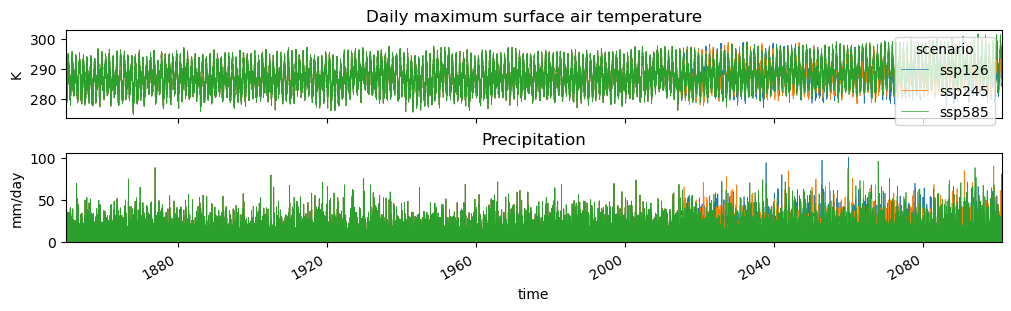

In [24]:
fig, ax = plt.subplots(2,sharex=True,figsize=(10,3),constrained_layout=True)
data_city['tasmax'].plot(hue='scenario',ax=ax[0],lw=0.5)
data_city['pr'].plot(hue='scenario',ax=ax[1],lw=0.5,add_legend=False)

ax[0].set_title('Daily maximum surface air temperature')
ax[1].set_title('Precipitation')

ax[0].set_xlabel('')

ax[0].set_ylabel('K')
ax[1].set_ylabel('mm/day')

ax[0].set_xlim(
    datetime(1850,1,1),
    datetime(2100,12,31)
)

ax[1].set_ylim(0,None)

In the previous tutorials we have been operating on annual maxima data - looking at the most extreme event observed in each year. We will do the same here: take the day in each year with the highest temperature or the largest amount of rainfall

(0.0, 104.62553188204765)

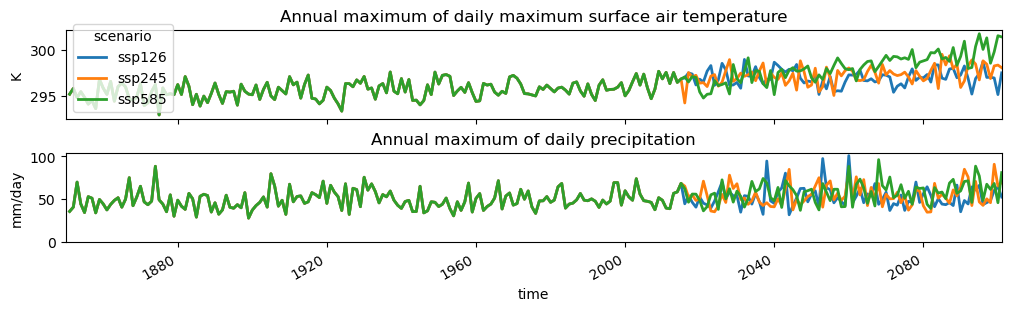

In [25]:
fig, ax = plt.subplots(2,sharex=True,figsize=(10,3),constrained_layout=True)
data_city['tasmax'].resample(time='1Y').max().plot(hue='scenario',ax=ax[0],lw=2)
data_city['pr'].resample(time='1Y').max().plot(hue='scenario',ax=ax[1],lw=2,add_legend=False)

ax[0].set_title('Annual maximum of daily maximum surface air temperature')
ax[1].set_title('Annual maximum of daily precipitation')

ax[0].set_xlabel('')

ax[0].set_ylabel('K')
ax[1].set_ylabel('mm/day')

ax[0].set_xlim(
    datetime(1850,1,1),
    datetime(2100,12,31)
)

ax[1].set_ylim(0,None)

### Exercise: 
Describe the plot - what do you see for the two variables, over time, between scenarios?

# Differences between historical periods:

Let's focus on precipitation for now, and compute the maximum for each year. As in the previous tutorial we want to compare consecutive 30-year periods in the past: therefore take the historical run (1850-2014), and look at the last three 30-year periods. We only need to look at one scenario because they all use the historical run until 2014.

In [26]:
pr_city = data_city['pr']
pr_city_max= pr_city.resample(time='1Y').max()

data_period1 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1925','1954')).to_pandas()
data_period2 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1955','1984')).to_pandas()
data_period3 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1985','2014')).to_pandas()

Plot the histograms of annual maximum daily precipitation for the three periods. What do you see? Compare to the analysis in the previous tutorial where we analysed sea level height. Any similarities or differences? Why do you think that is?

Text(0.5, 0, 'annual maximum daily precipitation (mm/day)')

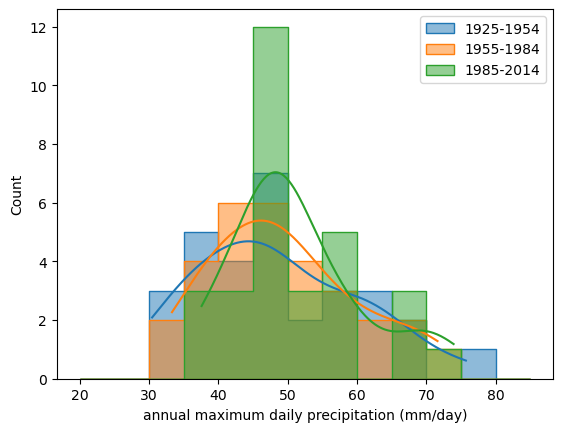

In [27]:
sns.histplot(data_period1,bins=np.arange(20,90,5),color='C0',element='step',alpha=0.5,kde=True,label='1925-1954')
sns.histplot(data_period2,bins=np.arange(20,90,5),color='C1',element='step',alpha=0.5,kde=True,label='1955-1984')
sns.histplot(data_period3,bins=np.arange(20,90,5),color='C2',element='step',alpha=0.5,kde=True,label='1985-2014')
plt.legend()
plt.xlabel('annual maximum daily precipitation (mm/day)')

In [28]:
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['1925-1954'] = [data_period1.mean(), data_period1.std(), data_period1.skew()]
periods_stats['1955-1984'] = [data_period2.mean(), data_period2.std(), data_period2.skew()]
periods_stats['1985-2014'] = [data_period3.mean(), data_period3.std(), data_period3.skew()]

periods_stats = periods_stats.T
periods_stats

,Mean,Standard Deviation,Skew
1925-1954,48.430939,11.521903,0.485490
1955-1984,49.461359,10.390394,0.547118
1985-2014,51.412866,9.354812,0.905246


Now, we fit a GEV to the three time periods, and plot the distributions using the gev.pdf function:

In [29]:
fit_period1, model_period1 = ef.fit_return_levels_sdfc(data_period1.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)
fit_period2, model_period2 = ef.fit_return_levels_sdfc(data_period2.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)
fit_period3, model_period3 = ef.fit_return_levels_sdfc(data_period3.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)

Text(0, 0.5, 'Density')

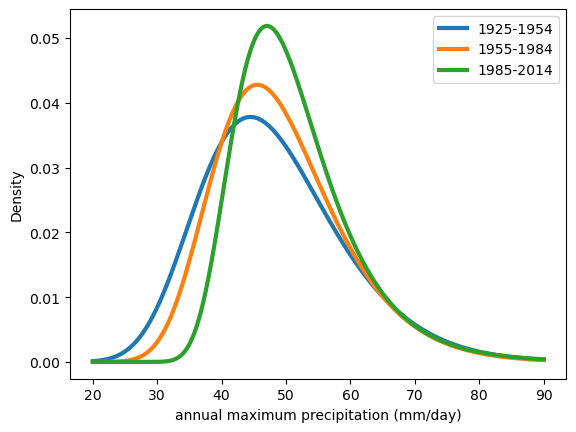

In [30]:
fig, ax = plt.subplots()
x = np.linspace(20,90,1000)
ax.plot(x,gev.pdf(
    x, 
    -model_period1.shape.mean(), 
    loc=model_period1.loc.mean(), 
    scale=model_period1.scale.mean()
    ),
    c='C0',lw=3,label='1925-1954')
ax.plot(x,gev.pdf(
    x, 
    -model_period2.shape.mean(), 
    loc=model_period2.loc.mean(), 
    scale=model_period2.scale.mean()
    ),
    c='C1',lw=3,label='1955-1984')
ax.plot(x,gev.pdf(
    x, 
    -model_period3.shape.mean(), 
    loc=model_period3.loc.mean(), 
    scale=model_period3.scale.mean()
    ),
    c='C2',lw=3,label='1985-2014')
ax.legend()
ax.set_xlabel('annual maximum precipitation (mm/day)')
ax.set_ylabel('Density')

In [31]:
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])
parameters['1925-1954'] = [model_period1.loc.mean(), model_period1.scale.mean(), model_period1.shape.mean()]
parameters['1955-1984'] = [model_period2.loc.mean(), model_period2.scale.mean(), model_period2.shape.mean()]
parameters['1985-2014'] = [model_period3.loc.mean(), model_period3.scale.mean(), model_period3.shape.mean()]

parameters = parameters.T
parameters.round(4)#.astype('%.2f')

,Location,Scale,Shape
1925-1954,43.5183,9.7693,-0.0931
1955-1984,44.9420,8.6152,-0.0673
1985-2014,47.1615,7.0916,0.0181


Create a return level plot for the three periods. What do you conclude for the historical change in extreme precipitation in this city? What possible limitations could this analysis have? (How) could we address this?

Text(0, 0.5, 'return level (mm/day)')

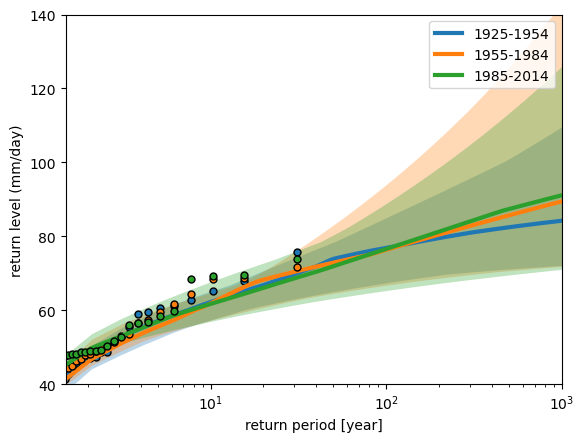

In [32]:
ef.plot_levels_from_obj(fit_period1,alpha=0.95,c='C0',label='1925-1954')
ef.plot_levels_from_obj(fit_period2,alpha=0.95,ax=plt.gca(),c='C1',label='1955-1984')
ef.plot_levels_from_obj(fit_period3,alpha=0.95,ax=plt.gca(),c='C2',label='1985-2014')

plt.xlim(1.5,1000)
plt.ylim(40,140)
# plt.semilogx()
plt.legend()
plt.ylabel('return level (mm/day)')

# Exercise: Differences between climate scenarios:

Now let's look at hot days in possible climate futures: the years 2071-2100 (the last 30 years). For comparison we use the historical period, 1850-2014 - where we use the entire 165 years because it gives us much nicer statistics!

In the next box we select the data:

In [33]:
data_city = data.sel(city=city,model='MPI-ESM1-2-HR')
# data_city = data.sel(city=city,model='MIROC6')
data_city_fut  = data_city['pr'].sel(time=slice('2071','2100')).resample(time='1Y').max()

# select the different time periods
data_hist = data_city['pr'].sel(scenario='ssp126',time=slice('1850','2014')).resample(time='1Y').max().to_pandas()
data_ssp126 = data_city_fut.sel(scenario='ssp126').to_pandas()
data_ssp245 = data_city_fut.sel(scenario='ssp245').to_pandas()
data_ssp585 = data_city_fut.sel(scenario='ssp585').to_pandas()

## Task: Repeat the analysis that we did above for three different time periods, now for three different climate scenarios, and the historical period for comparison.
1. Create a figure that displays the histograms of the four records. Find a useful number and spacing of bins (via the bins= keyword to sns.histplot). Think what the comparison tells you.
2. Fit GEV distributions to the four records using the same commands as above. Use the gev.pdf function to plot the fitted distributions.
3. Inspect location, scale and shape parameters
4. Create a return-level plot using the ef.plot_levels_from_obj function.

What can you say about how extreme precipitation differs between the climate scenarios? Are the differences large or small compared to periods in the historical records? What are the limitations? Consider the x-axis in the return-level plot compared to the space covered by the data (only 30 years). How could we get more information for longer return periods?

### student

In [34]:
...

Ellipsis

### solution

Text(0.5, 0, 'annual maximum daily precipitation (mm/day)')

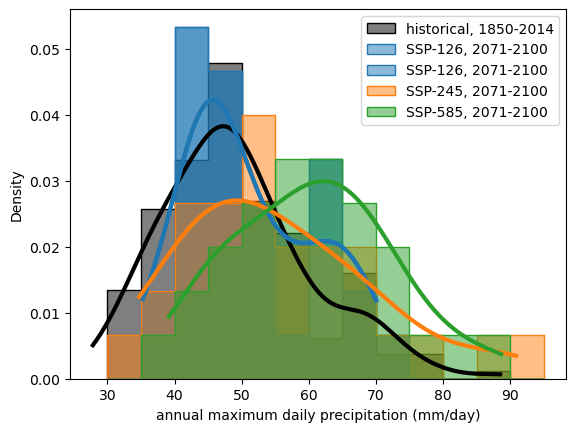

In [35]:
sns.histplot(data_hist,bins=np.arange(30,100,5),color='k',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='historical, 1850-2014')
sns.histplot(data_ssp126,bins=np.arange(30,100,5),color='C0',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-126, 2071-2100')
sns.histplot(data_ssp126,bins=np.arange(30,100,5),color='C0',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-126, 2071-2100')
sns.histplot(data_ssp245,bins=np.arange(30,100,5),color='C1',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-245, 2071-2100')
sns.histplot(data_ssp585,bins=np.arange(30,100,5),color='C2',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-585, 2071-2100')
plt.legend()

plt.xlabel('annual maximum daily precipitation (mm/day)')

In [36]:
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['hist'] = [data_hist.mean(), data_hist.std(), data_hist.skew()]
periods_stats['ssp126'] = [data_ssp126.mean(), data_ssp126.std(), data_ssp126.skew()]
periods_stats['ssp245'] = [data_ssp245.mean(), data_ssp245.std(), data_ssp245.skew()]
periods_stats['ssp585'] = [data_ssp585.mean(), data_ssp585.std(), data_ssp585.skew()]

periods_stats = periods_stats.T
periods_stats

,Mean,Standard Deviation,Skew
hist,49.269219,11.119333,0.693951
ssp126,51.130332,9.557283,0.476350
ssp245,55.264835,14.017823,0.764946
ssp585,60.534207,11.782039,0.276712


In [37]:
fit_hist, model_hist = ef.fit_return_levels_sdfc(data_hist.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)
fit_ssp126, model_ssp126 = ef.fit_return_levels_sdfc(data_ssp126.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)
fit_ssp245, model_ssp245 = ef.fit_return_levels_sdfc(data_ssp245.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)
fit_ssp585, model_ssp585 = ef.fit_return_levels_sdfc(data_ssp585.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)

Text(0, 0.5, 'Density')

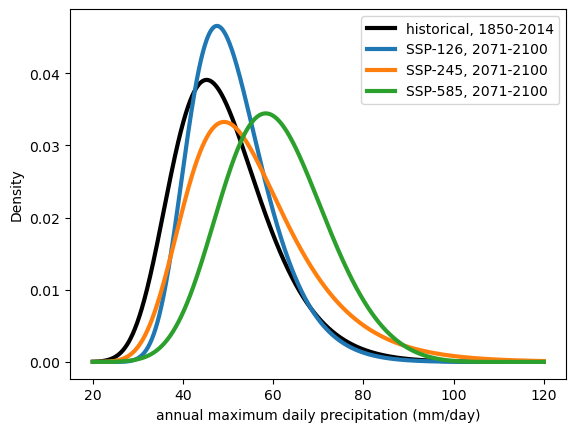

In [38]:
fig, ax = plt.subplots()
# x = np.linspace(293,302,1000)
x = np.linspace(20,120,1000)
ax.plot(x,gev.pdf(
    x, 
    -model_hist.shape.mean(), 
    loc=model_hist.loc.mean(), 
    scale=model_hist.scale.mean()
    ),
    c='k',lw=3,label='historical, 1850-2014')
ax.plot(x,gev.pdf(
    x, 
    -model_ssp126.shape.mean(), 
    loc=model_ssp126.loc.mean(), 
    scale=model_ssp126.scale.mean()
    ),
    c='C0',lw=3,label='SSP-126, 2071-2100')
ax.plot(x,gev.pdf(
    x, 
    -model_ssp245.shape.mean(), 
    loc=model_ssp245.loc.mean(), 
    scale=model_ssp245.scale.mean()
    ),
    c='C1',lw=3,label='SSP-245, 2071-2100')
ax.plot(x,gev.pdf(
    x, 
    -model_ssp585.shape.mean(), 
    loc=model_ssp585.loc.mean(), 
    scale=model_ssp585.scale.mean()
    ),
    c='C2',lw=3,label='SSP-585, 2071-2100')
ax.legend()
ax.set_xlabel('annual maximum daily precipitation (mm/day)')
ax.set_ylabel('Density')

In [39]:
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])
parameters['hist'] = [model_hist.loc.mean(), model_hist.scale.mean(), model_hist.shape.mean()]
parameters['ssp126'] = [model_ssp126.loc.mean(), model_ssp126.scale.mean(), model_ssp126.shape.mean()]
parameters['ssp245'] = [model_ssp245.loc.mean(), model_ssp245.scale.mean(), model_ssp245.shape.mean()]
parameters['ssp585'] = [model_ssp585.loc.mean(), model_ssp585.scale.mean(), model_ssp585.shape.mean()]

parameters = parameters.T
parameters.round(4)#.astype('%.2f')

,Location,Scale,Shape
hist,44.4731,9.4418,-0.0777
ssp126,46.9651,7.9202,-0.0690
ssp245,48.9565,11.0625,-0.0133
ssp585,56.0056,10.9053,-0.1969


Text(0, 0.5, 'return level (mm/day)')

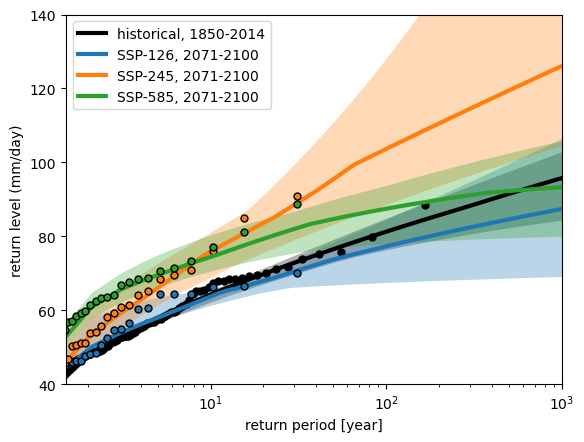

In [40]:
ef.plot_levels_from_obj(fit_hist,alpha=0.95,c='k',label='historical, 1850-2014')
ef.plot_levels_from_obj(fit_ssp126,alpha=0.95,ax=plt.gca(),c='C0',label='SSP-126, 2071-2100')
ef.plot_levels_from_obj(fit_ssp245,alpha=0.95,ax=plt.gca(),c='C1',label='SSP-245, 2071-2100')
ef.plot_levels_from_obj(fit_ssp585,alpha=0.95,ax=plt.gca(),c='C2',label='SSP-585, 2071-2100')
plt.xlim(1.5,1000)
plt.ylim(40,140)
# plt.semilogx()
plt.legend()
plt.ylabel('return level (mm/day)')